## Spark Initializing

In [1]:
import findspark
findspark.init()
import pyspark
import pandas as pd
import seaborn as sns # To get graphs
import matplotlib.pyplot as plt # To get graphs

In [2]:
#### First we have create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
                    .appName('Clustering') \
                    .getOrCreate()

In [3]:
spark

### Importing Data Set

In [4]:
df = spark.read.option("header" , True).csv("/Users/Asus/Documents/InternCsv/combine_final.csv")

In [5]:
df.show()

+-------------+--------+----+---------------+-------------------+----------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|
+-------------+--------+----+---------------+-------------------+----------+
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|
|     KPS(GT7)|7/1/2020|0:00|              0|                  0|         0|
|         Polp|7/1/2020|0:00|             40|                 78|       -38|
|          WPS|7/1/2020|0:00|              0|                  0|         0|
|         Rand|7/1/2020|0:00|              0|                  0|         0|
|VPOWER Horona|7/1/2020|0:00|              0|                  0|         0|
|       LVPS 2|7/1/2020|0:00|            540|                270|       270|
|          Uku|7/1/2020|0:00|             72|                 40|        32|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|

In [6]:
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
df_dev = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date","Time","Plant")))

In [7]:
train_df = df_dev.where("rank <= .8").drop("rank")
train_df.show()

+-------------+--------+----+---------------+-------------------+----------+
|        Plant|    Date|Time|Actual_Dispatch|Forecasted_Dispatch|Difference|
+-------------+--------+----+---------------+-------------------+----------+
|     ACE EMBP|7/1/2020|0:00|              0|                 51|       -51|
|   ACE Matara|7/1/2020|0:00|              0|                  0|         0|
|ALTAQQA-Mahi.|7/1/2020|0:00|              0|                  0|         0|
| ALTAQQA-Pol.|7/1/2020|0:00|              0|                  0|         0|
|   Asia Power|7/1/2020|0:00|              0|                 33|       -33|
|        Barge|7/1/2020|0:00|             90|                 45|        45|
|         Bowa|7/1/2020|0:00|              0|                  0|         0|
|CEB Sup Power|7/1/2020|0:00|              0|                  0|         0|
|       Canyon|7/1/2020|0:00|             20|                  0|        20|
|         KCCP|7/1/2020|0:00|              0|                  0|         0|

In [8]:
train_df = train_df.withColumn("Difference",train_df.Difference.cast('double'))
train_df = train_df.withColumn("Actual_Dispatch",train_df.Actual_Dispatch.cast('double'))
train_df = train_df.withColumn("Forecasted_Dispatch",train_df.Forecasted_Dispatch.cast('double'))

In [9]:
train_df.dtypes

[('Plant', 'string'),
 ('Date', 'string'),
 ('Time', 'string'),
 ('Actual_Dispatch', 'double'),
 ('Forecasted_Dispatch', 'double'),
 ('Difference', 'double')]

In [10]:
from pyspark.sql.functions import col
sumtot = train_df.groupBy("Plant").sum("Actual_Dispatch","Forecasted_Dispatch","Difference").sort(col("Plant").asc())

In [11]:
sumtot.show(5)

+-------------+--------------------+------------------------+---------------+
|        Plant|sum(Actual_Dispatch)|sum(Forecasted_Dispatch)|sum(Difference)|
+-------------+--------------------+------------------------+---------------+
|     ACE EMBP|            134409.0|                 61367.0|        73042.0|
|   ACE Matara|             27330.0|                 14225.0|        13105.0|
|ALTAQQA-Mahi.|              1451.0|                   650.0|          801.0|
| ALTAQQA-Pol.|              1656.0|                   528.0|         1128.0|
|   Asia Power|             34513.0|                 23497.0|        11016.0|
+-------------+--------------------+------------------------+---------------+
only showing top 5 rows



In [12]:
from pyspark.sql.functions import *
newColumns = ["Plant","Actual_Dispatch","Forecasted_Dispatch","DispatchDiff"]
sumtot=sumtot.toDF(*newColumns)

In [13]:
df1 = sumtot.toPandas()
df1.head()

,Plant,Actual_Dispatch,Forecasted_Dispatch,DispatchDiff
0,ACE EMBP,134409.0,61367.0,73042.0
1,ACE Matara,27330.0,14225.0,13105.0
2,ALTAQQA-Mahi.,1451.0,650.0,801.0
3,ALTAQQA-Pol.,1656.0,528.0,1128.0
4,Asia Power,34513.0,23497.0,11016.0


In [14]:
# df description

df1.describe()

,Actual_Dispatch,Forecasted_Dispatch,DispatchDiff
count,36.000000,36.000000,36.000000
mean,95874.638889,48965.472222,46909.166667
std,161125.799270,80548.080869,80670.562802
min,0.000000,0.000000,-4599.000000
25%,10791.750000,4581.000000,6333.000000
50%,36565.500000,20917.000000,16650.500000
75%,84124.750000,47332.000000,42021.750000
max,562074.000000,279720.000000,282584.000000


### Clustering Data Set

In [15]:
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Finding Outliers

**There are 2 types of outliers and we will treat outliers as it can skew our dataset**

Statistical

Domain specific

Text(0.5, 0, 'Attributes')

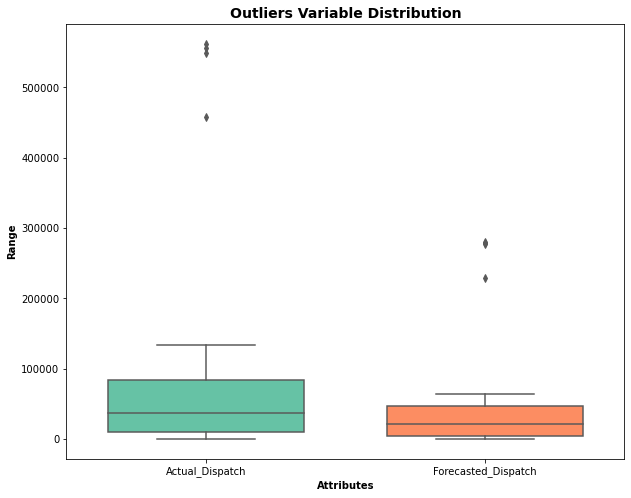

In [16]:
attributes = ['Actual_Dispatch','Forecasted_Dispatch']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df1[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [17]:
# Removing (statistical) outliers for Actual_Dispatch
Q1 = df1.Actual_Dispatch.quantile(0.05)
Q3 = df1.Actual_Dispatch.quantile(0.95)
IQR = Q3 - Q1
df1 = df1[(df1.Actual_Dispatch >= Q1 - 1.5*IQR) & (df1.Actual_Dispatch <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for 
Q1 = df1.Forecasted_Dispatch.quantile(0.05)
Q3 = df1.Forecasted_Dispatch.quantile(0.95)
IQR = Q3 - Q1
df1 = df1[(df1.Forecasted_Dispatch >= Q1 - 1.5*IQR) & (df1.Forecasted_Dispatch <= Q3 + 1.5*IQR)]



## Rescaling the Attributes
**It is extremely important to rescale the variables so that they have a comparable scale.| There are two common ways of rescaling:**

1) Min-Max scaling

2) Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [18]:
# Rescaling the attributes

rfm_df = df1[['Actual_Dispatch','Forecasted_Dispatch']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(36, 2)

In [20]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Actual_Dispatch','Forecasted_Dispatch']
rfm_df_scaled.head()

,Actual_Dispatch,Forecasted_Dispatch
0,0.242549,0.156148
1,-0.431445,-0.437419
2,-0.594337,-0.608343
3,-0.593047,-0.609879
4,-0.386233,-0.320675


**K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.**

**The algorithm works as follows:**

First we initialize k points, called means, randomly.

We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.

We repeat the process for a given number of iterations and at the end, we have our clusters.

In [21]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [22]:
kmeans.labels_

array([2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0])

**Finding the Optimal Number of Clusters**

**Elbow Curve to get the right number of Clusters**

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

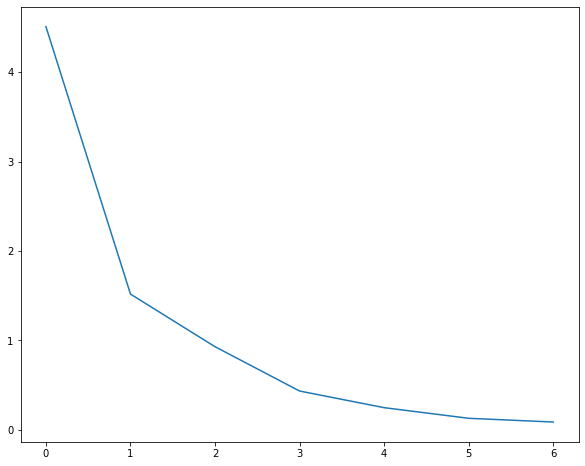

In [23]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

**silhouette score=(p−q) / max(p,q)**

p is the mean distance to the points in the nearest cluster that the data point is not a part of

q is the mean intra-cluster distance to all the points in its own cluster.

1) The value of the silhouette score range lies between -1 to 1.

2) A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

3) A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [24]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.902772587775885
For n_clusters=3, the silhouette score is 0.6768552682465468
For n_clusters=4, the silhouette score is 0.6579666274159333
For n_clusters=5, the silhouette score is 0.5961496017511657
For n_clusters=6, the silhouette score is 0.5684812032008631
For n_clusters=7, the silhouette score is 0.6137418201011827
For n_clusters=8, the silhouette score is 0.6075209419084975


**According to silhouette score & Elbow Curve Ideal Clusters for the Plants will be 4**

In [25]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [26]:
kmeans.labels_

array([0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 2, 2,
       2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 3, 2])

In [27]:
# assign the label
df1['Cluster_Id'] = kmeans.labels_
df1.head()

,Plant,Actual_Dispatch,Forecasted_Dispatch,DispatchDiff,Cluster_Id
0,ACE EMBP,134409.0,61367.0,73042.0,0
1,ACE Matara,27330.0,14225.0,13105.0,2
2,ALTAQQA-Mahi.,1451.0,650.0,801.0,2
3,ALTAQQA-Pol.,1656.0,528.0,1128.0,2
4,Asia Power,34513.0,23497.0,11016.0,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Plant'>

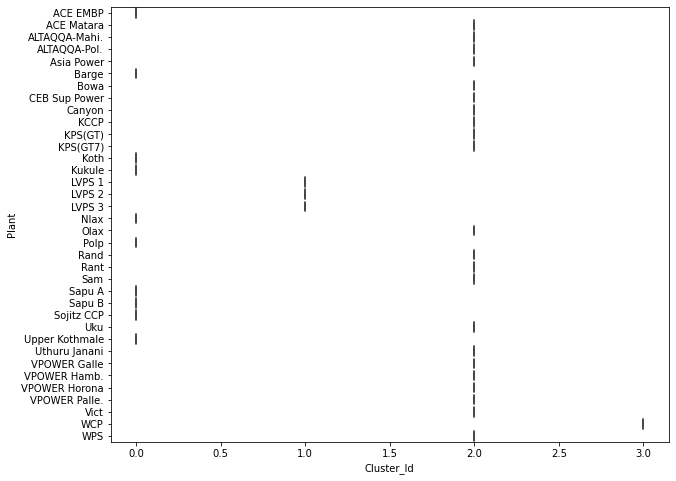

In [28]:
# Box plot to visualize Cluster Id vs Plant

sns.boxplot(x='Cluster_Id', y='Plant', data=df1)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Actual_Dispatch'>

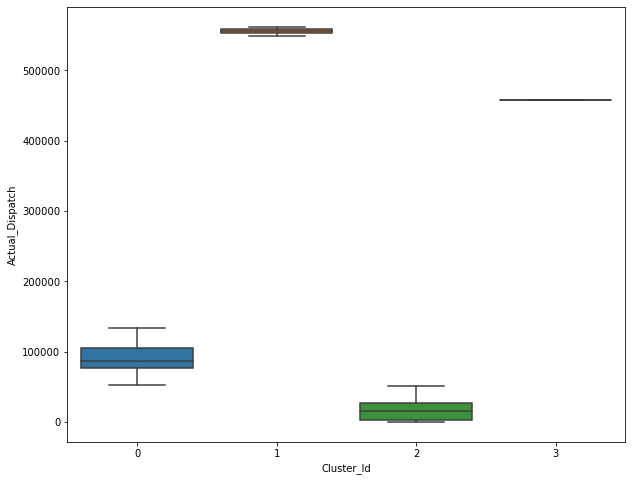

In [29]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Actual_Dispatch', data=df1)

## Hierarchical Clustering

**Hierarchical clustering** involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,

1) Divisive

2) Agglomerative.

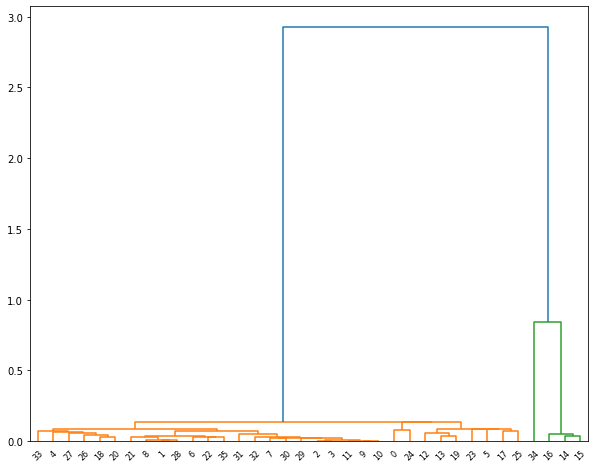

In [30]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.

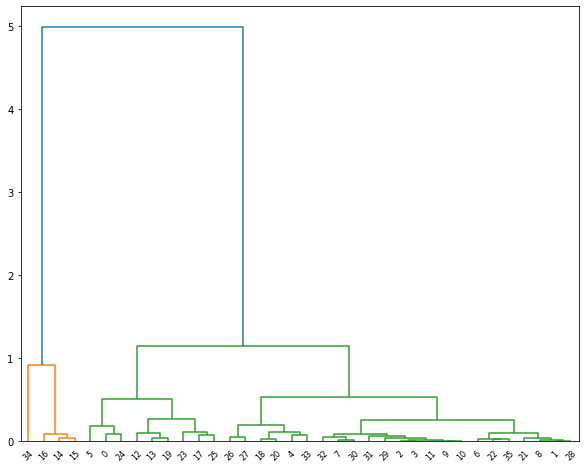

In [31]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage:**

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other

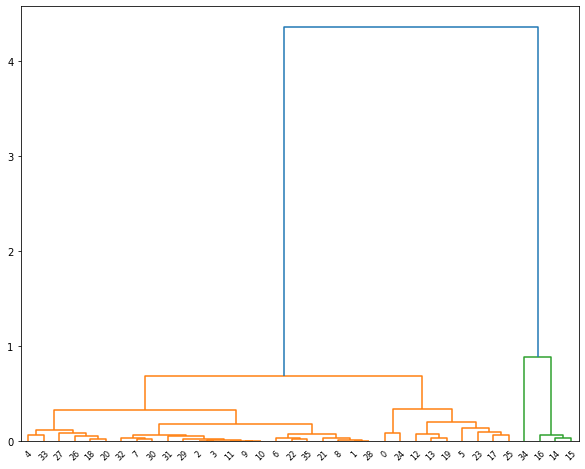

In [32]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

## Cutting the Dendrogram based on K

In [33]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0])

In [34]:
# Assign cluster labels

df1['Cluster_Labels'] = cluster_labels
df1.head()

,Plant,Actual_Dispatch,Forecasted_Dispatch,DispatchDiff,Cluster_Id,Cluster_Labels
0,ACE EMBP,134409.0,61367.0,73042.0,0,0
1,ACE Matara,27330.0,14225.0,13105.0,2,0
2,ALTAQQA-Mahi.,1451.0,650.0,801.0,2,0
3,ALTAQQA-Pol.,1656.0,528.0,1128.0,2,0
4,Asia Power,34513.0,23497.0,11016.0,2,0


<AxesSubplot:xlabel='Cluster_Labels', ylabel='Plant'>

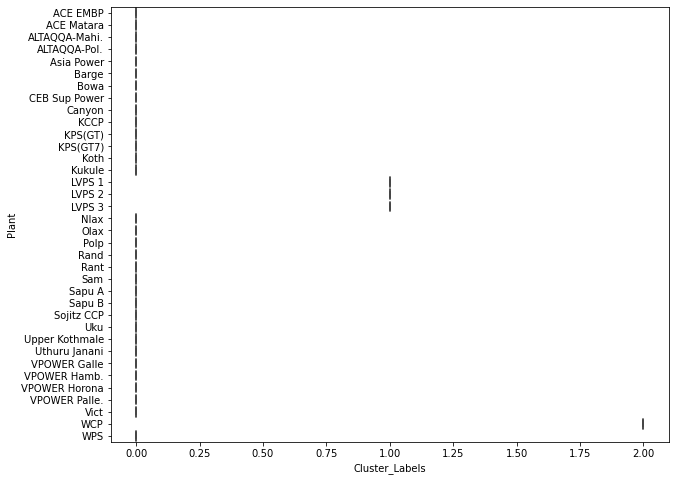

In [36]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Plant', data=df1)

### Final Analysis
**Inference:**
***K-Means Clustering with 4 Cluster Ids***

Plants with Cluster Id 2 are the most common Dispatches Produced in July.

Plants with Cluster Id 2 are Common Dispatch Produces.
